In this notebook, I use two methods to do topic analysis on the CORD-19 articles in 2021. Hope you enjoy it!

# Fundamental Ideas Preview

**1. Text Cleaning and Preprocessing**

**2. Inverted Index**

**3. Latent Dirichlet Allocation**

**4. T-SNE**

**5. Bert**

**6. K-Means Clustering**

**7. TF-IDF**

**8. AutoEncoder**

In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 78 kB 972 kB/s eta 0:00:011
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-py3-none-any.whl size=119616 sha256=27a63f4973bec67f1ba55a595a729a9ee6490d8b33e3b05d08277cee04eb278d
  Stored in directory: /root/.cache/pip/wheels/20/fd/72/b2524b6c3af92dae3ce173595aeff673a8114255809a9aa381
Successfully built sentence-transformers


In [2]:
import pandas as pd 
import numpy as np
from tqdm import tqdm 
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import pyLDAvis.gensim_models
from sentence_transformers import SentenceTransformer
import warnings
import pprint
import tensorflow as tf

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,


# Data Preprocessing

In [3]:
data = pd.read_csv('../input/CORD-19-research-challenge/metadata.csv',
                  usecols=['cord_uid','source_x','title','license','publish_time',
                           'abstract','authors','journal','url'])
data.head()

cord_uid source_x                                              title  \
0  ug7v899j      PMC  Clinical features of culture-proven Mycoplasma...   
1  02tnwd4m      PMC  Nitric oxide: a pro-inflammatory mediator in l...   
2  ejv2xln0      PMC    Surfactant protein-D and pulmonary host defense   
3  2b73a28n      PMC               Role of endothelin-1 in lung disease   
4  9785vg6d      PMC  Gene expression in epithelial cells in respons...   

  license                                           abstract publish_time  \
0   no-cc  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1   no-cc  Inflammatory diseases of the respiratory tract...   2000-08-15   
2   no-cc  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3   no-cc  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4   no-cc  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res   
2                                    Crouch, Erika C      Respir Res   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res   

                                                 url  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...

In [4]:
data = data[data.publish_time=='2021']
print(f'There are {len(data)} articles published in 2021')

There are 46272 articles published in 2021


In [5]:
len1 = len(data)
data.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
print(f'Dropped {len1-len(data)} articles with missing abstract')

Dropped 12236 articles with missing abstract


In [6]:
len1 = len(data)
data.drop_duplicates(subset=['abstract'],keep='first',inplace=True)
print(f'Dropped {len1-len(data)} articles with duplicate abstract')

Dropped 2192 articles with duplicate abstract


Warning: Although the articles with duplicated abstracts are dropped, there still exist some articles with meaningless abstracts. The cleaning strategy here only weakens the effects of those meaningless abstracts.  

In [7]:
data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())
stopwords = set(stopwords.words('english'))
data['abstract_tokens'] = data['abstract'].apply(lambda x: word_tokenize(x))

## Remove non-English words
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w.isalpha()])

## Remove Stopwords
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords])

## Remove words with single characters
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if len(w)>1])
#data['abstract_cleaned'] = data['abstract_tokens'].apply(lambda x: ' '.join(x))
data.head()

cord_uid source_x                                              title  \
15426  ilsrad9a      PMC          Tomographic findings in bronchial atresia   
15626  eysbfj2i      PMC   Environmental air pollution: respiratory effects   
16620  30svjjwj      PMC  In Vitro Antileishmanial Effects of Saffron Co...   
42072  36budc48      PMC  Assessment of prevalence of Anxiety in adult p...   
45853  31sylkes      PMC                                              Italy   

        license                                           abstract  \
15426     cc-by  objective: to evaluate computed tomography (ct...   
15626  cc-by-nc  environmental air pollution is a major risk fa...   
16620  cc-by-nc  background: due to numerous side effects of co...   
42072     cc-by  objective: to develop an indigenous anxiety sc...   
45853     no-cc  excavations at isernia have uncovered remains ...   

      publish_time                                            authors  \
15426         2021  Puglia, Elazir Barbosa Mota Di; Rodrigues, Ros...   
15626         2021  Santos, Ubiratan de Paula; Arbex, Marcos Abdo;...   
16620         2021  RANJBAR, Reza; SHAYANFAR, Peyman; MANIATI, Mah...   
42072         2021           Bano, Zaqia; Ejaz, Maria; Ahmad, Ishtiaq   
45853         2021                                                NaN   

                                     journal  \
15426                            Radiol Bras   
15626                         J Bras Pneumol   
16620                       Iran J Parasitol   
42072                          Pak J Med Sci   
45853  The Statesman&#x02019;s Yearbook 2021   

                                                     url  \
15426  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...   
15626  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...   
16620  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...   
42072  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...   
45853  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...   

                                         abstract_tokens  
15426  [objective, evaluate, computed, tomography, ct...  
15626  [environmental, air, pollution, major, risk, f...  
16620  [background, due, numerous, side, effects, com...  
42072  [objective, develop, indigenous, anxiety, scal...  
45853  [excavations, isernia, uncovered, remains, pal...

In [8]:
data.reset_index(drop=True,inplace=True)

Here I create inverted index. Inverted index is a fundamental technology used commonly in search engine .  Inverted index assigns each word with a list of document id and it helps retrieve the articles with keyword matching fastly. For example {'patient':[1,3,6]} means that the word patient occurs in the second,fourth and sixth document in the corpus.

In [9]:
inverted_idx = {}
for idx,sentence in enumerate(list(data['abstract_tokens'])):
    for token in set(sentence):
        if token not in inverted_idx:
            inverted_idx[token] = [idx]
        else:
            inverted_idx[token].append(idx)

print(f'There are {len(inverted_idx)} unique words in inverted index')

There are 70464 unique words in inverted index


# Article Matching and Deep Cleaning

In [10]:
keywords_risk = ['risk','risky','risks','risked','risking']
risk_idx = []
for word in keywords_risk:
    try:
        risk_idx += inverted_idx[word]
    except:
        pass
risk_idx = list(set(risk_idx))
print(f'Found {len(risk_idx)} articles related to risk')

Found 7055 articles related to risk


In [11]:
risk_article = data.iloc[risk_idx,:]
risk_article.head()

cord_uid source_x                                              title  \
1   eysbfj2i      PMC   Environmental air pollution: respiratory effects   
11  bdcajgsj  Medline  Knowledge, attitudes, and practices towards CO...   
12  g927opm0  Medline  Internet of Things (IoT) enabled healthcare he...   
17  a1p1vnh1  Medline              Early Life Stage Assays in Zebrafish.   
23  kih3e5ib  Medline  [Practical management of the patients with hem...   

     license                                           abstract publish_time  \
1   cc-by-nc  environmental air pollution is a major risk fa...         2021   
11       unk  background covid-19 threatens health systems w...         2021   
12       unk  background/objectives the internet of things (...         2021   
17       unk  fish embryo toxicity (fet) test using zebrafis...         2021   
23       unk  pcr assay cannot always detect the sars-cov2 v...         2021   

                                              authors  \
1   Santos, Ubiratan de Paula; Arbex, Marcos Abdo;...   
11  Bates, Benjamin R; Tami, Adriana; Carvajal, An...   
12                 Javaid, Mohd; Khan, Ibrahim Haleem   
17  Abe, Flávia Renata; Accoroni, Klaus Alvaro Gue...   
23  Hagihara, Masao; Ohara, Shin; Uchida, Tomoyuki...   

                                              journal  \
1                                      J Bras Pneumol   
11                                           PloS one   
12  Journal of oral biology and craniofacial research   
17                       Methods in molecular biology   
23  [Rinsho ketsueki] The Japanese journal of clin...   

                                                  url  \
1   https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...   
11  https://doi.org/10.1371/journal.pone.0249022; ...   
12  https://doi.org/10.1016/j.jobcr.2021.01.015; h...   
17  https://doi.org/10.1007/978-1-0716-1091-6_7; h...   
23  https://doi.org/10.11406/rinketsu.62.115; http...   

                                      abstract_tokens  
1   [environmental, air, pollution, major, risk, f...  
11  [background, threatens, health, systems, world...  
12  [internet, things, iot, create, disruptive, in...  
17  [fish, embryo, toxicity, fet, test, using, zeb...  
23  [pcr, assay, always, detect, virus, might, due...

For topic modeling and visualization, lemmatization is needed. POS tagging technique is also used to filter meaningful words. 

In [12]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        ##'-PRON-' is used as the lemma for all pronouns such as their, you, me, and I
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                          for token in doc if token.pos_ in allowed_postags])
    return texts_out   

First, let's see how the word cloud of this corpus looks like.

Text(0.5, 1.0, 'Word Cloud: Articles Related to Risk Factor')

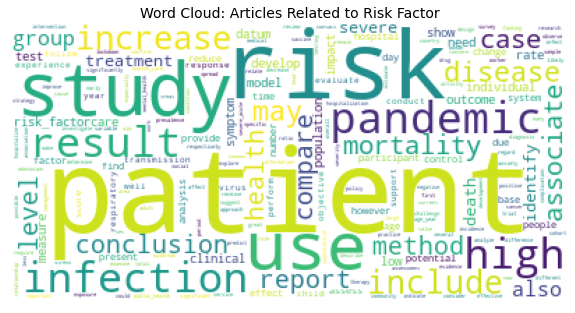

In [13]:
risk_article['Lemma_Tokens'] = lemmatization(list(risk_article['abstract_tokens']))
## convert tokens that frequently occur together as bigram and trigram
bigram = Phrases(list(risk_article['Lemma_Tokens']), min_count=3)
risk_article['Phrase_Lemma_Tokens'] = risk_article['Lemma_Tokens'].apply(lambda x: bigram[x])
#trigram = Phrases(list(risk_article['Phrase_Lemma_Tokens']), min_count=5)
#risk_article['Phrase_Lemma_Tokens'] = risk_article['Phrase_Lemma_Tokens'].apply(lambda x: trigram[x])

risk_abstract_tokens = []
for tokens in list(risk_article['Phrase_Lemma_Tokens']):
    risk_abstract_tokens += tokens
risk_wordcnt_dict = collections.Counter(risk_abstract_tokens)

wcloud = wordcloud.WordCloud(background_color='white')
wcloud.generate_from_frequencies(risk_wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: Articles Related to Risk Factor' ,fontsize=14)

Words or phrases like 'risk', 'result', 'patient', 'infection', 'disease', 'study' occur frequently in this corpus.

# Topic Extraction I: LDA

For topic modeling in python, LDA model are available and fast to implement with the help of either two libraries (sklearn and genism). 

sklearn LDA pipeline: CounterVectorizer + LatentDirichletAllocation + GridSearchCV

In [14]:
#vectorizer = CountVectorizer()
#risk_article_bow = vectorizer.fit_transform(
#    [' '.join(tokens) for tokens in list(risk_article['Lemma_Tokens'])])

#search_params = {'n_components': range(1,20)}
#LDA_model = LatentDirichletAllocation(max_iter=10,learning_method='batch', 
#                                      random_state=98, n_jobs=-1)
#model = GridSearchCV(LDA_model, param_grid=search_params)
#LDA_model.fit_transform(risk_article_bow)
#model.fit(risk_article_bow)

#print("Best Model's Params: ", model.best_params_)
#print("Best Log Likelihood Score: ", model.best_score_)

#LDA_model = LatentDirichletAllocation(**model.best_params_)
#LDA_model.fit(risk_article_bow)
#LDA_model.perplexity(risk_article_bow)

gensim pipeline: Dictionary + doc2bow + LdaModel + CoherenceModel

100%|██████████| 8/8 [06:00<00:00, 45.01s/it]

Topic number selection took 360.08135890960693 seconds


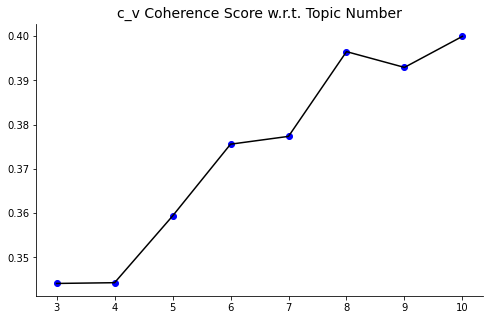

In [15]:
##https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
id2token_risk_article = corpora.Dictionary(list(risk_article['Phrase_Lemma_Tokens']))
##eliminate rare and frequent tokens
#id2token_risk_article.filter_extremes(no_below=2, no_above=0.8, 
#                                       keep_tokens=['smoke','smoking','smoker'])
corpus_risk_article = [id2token_risk_article.doc2bow(tokens) 
                        for tokens in list(risk_article['Phrase_Lemma_Tokens'])]

begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(3,11)):
    lda_model = LdaMulticore(corpus=corpus_risk_article,
                            id2word=id2token_risk_article,
                            num_topics=nb_topics, 
                            random_state=98,
                            chunksize=100,
                            passes=10,
                            iterations=50,
                            decay=0.5,
                            per_word_topics=True,)
    #cm = CoherenceModel(model=lda_model, corpus=corpus_smoke_article, coherence='u_mass')
    cm = CoherenceModel(model=lda_model, 
                        texts=list(risk_article['Phrase_Lemma_Tokens']),
                        dictionary=id2token_risk_article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)
    
print(f'Topic number selection took {time.time()-begin_time} seconds')

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(3,11),coherence_scores,color='black')
ax.scatter(range(3,11),coherence_scores,marker='o',color='blue')
ax.set_xticks(range(3,11,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)
#ax.set_xlabel('Number of Topics',fontsize=14)
for pos in ['top','right']:
    ax.spines[pos].set_color(None)

The higher the c_v coherence score is, the more suitable the topic number should be. However, the coherence score will vary if we run the iteration different times. Hence, I choose 6 as the topic number for analysis.

In [16]:
lda_model = LdaMulticore(corpus=corpus_risk_article,
                        id2word=id2token_risk_article,
                        num_topics=6, 
                        random_state=98,
                        chunksize=100,
                        passes=10,
                        iterations=50,
                        decay=0.5,
                        per_word_topics=True,)

print('Perplexity: ', lda_model.log_perplexity(corpus_risk_article))

Perplexity:  -7.8371573063332844


## Word per Topic

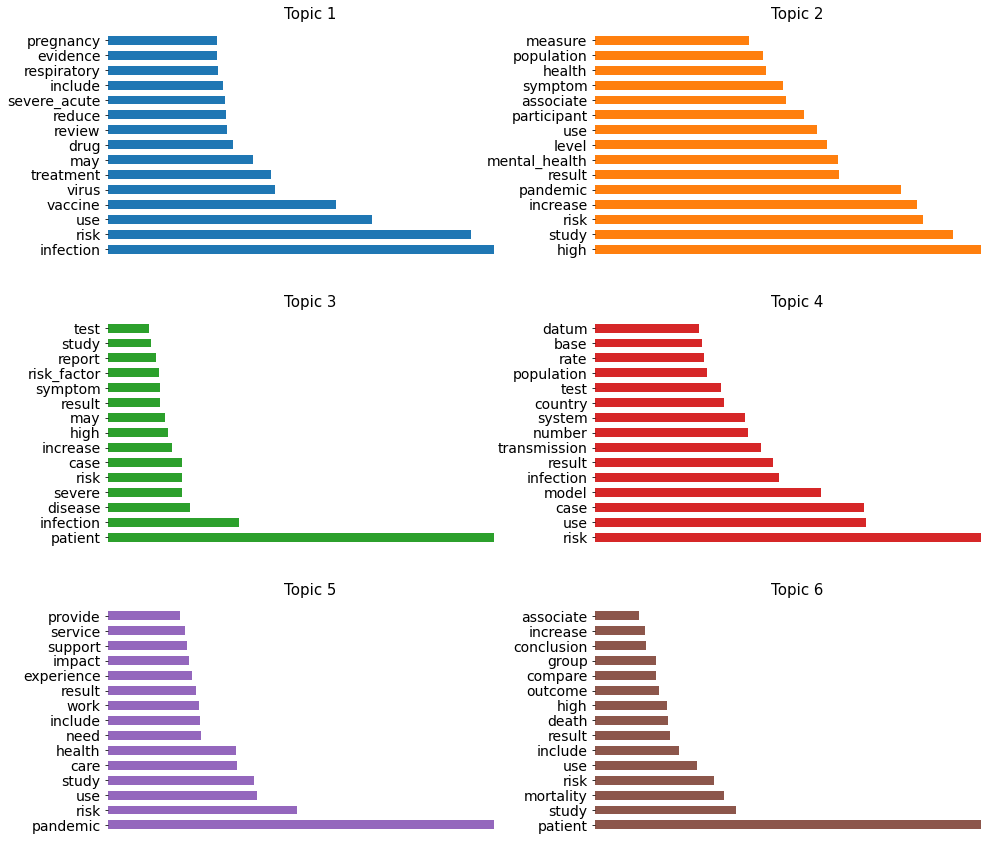

In [17]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    #fig,ax = plt.subplots(figsize=(7,5))
    ax = fig.add_subplot(3,2,i+1)
    ax.barh(y=words,width=probs,height=0.6,color=sns.color_palette()[i])
    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

1. The first topic is probably talking about treatment methods. We can see the word like 'vaccine','drug','treatment','procedure'. 
2. The second topic is probably talking about mental health of people during panademic. We can see the word like 'mental_health','panademic'.
3. The third topic is probably talking about the severity of disease . We can see the word like 'severe','patient','infection'.
4. The fourth topic is probably talking about the transmission dynamics of the virus. We can see the word like 'transmission','country','population'.
5. The fifth topic is probably talking about the public service and work during panademic. We can see the word like 'care','service','support','work'.
6. The sixth topic is probably talking about the death. We can see the word like 'mortality','death','conclusion'.

In [18]:
%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus_risk_article, id2token_risk_article)

CPU times: user 5.08 s, sys: 216 ms, total: 5.29 s
Wall time: 8.11 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.137680  0.110685       1        1  21.612894
5      0.177669 -0.036297       2        1  21.198632
2      0.103539 -0.131764       3        1  18.141907
3     -0.114062  0.032755       4        1  15.707219
1      0.111392  0.168622       5        1  12.918615
0     -0.140858 -0.144001       6        1  10.420733, topic_info=              Term          Freq         Total Category  logprob  loglift
234        patient  16103.000000  16103.000000  Default  30.0000  30.0000
872      mortality   3080.000000   3080.000000  Default  29.0000  29.0000
328      infection   5031.000000   5031.000000  Default  28.0000  28.0000
231       pandemic   5871.000000   5871.000000  Default  27.0000  27.0000
679  mental_health   1019.000000   1019.000000  Default  26.0000  26.0000
..             ...           ...           ...      ...      ...      ...
231       pandemic    344.092038   5871.000163   Topic6  -5.3704  -0.5755
5             also    278.370257   2137.918820   Topic6  -5.5823   0.2227
234        patient    351.425506  16103.060726   Topic6  -5.3493  -1.5634
22         disease    265.977253   3037.602693   Topic6  -5.6279  -0.1740
107           high    262.150076   5094.211887   Topic6  -5.6424  -0.7056

[500 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1249      3  0.988609    abdominal
9222      6  0.969213     abortion
4488      1  0.994433   acceptance
356       1  0.837309       access
356       2  0.020422       access
...     ...       ...          ...
1185      6  0.111969       worker
3024      1  0.020343  young_adult
3024      3  0.030515  young_adult
3024      5  0.956142  young_adult
9221      6  0.977545        youth

[1050 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 3, 4, 2, 1])

As we can see from the interactive figure above, topic 4 and 5 (1 and 4 in the figure) are very close. The other topics are separated appropriately.

## Topic per Document

In [19]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_risk_article)):
    document_topic = lda_model.get_document_topics(corpus_risk_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

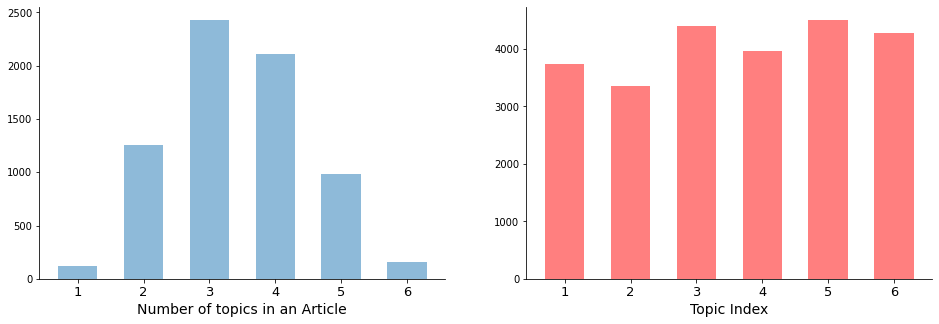

In [20]:
#num_topic_document_counter = collections.Counter(num_topic_document)
num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6'],fontsize=13)

1. The left figure shows that there are very few articles cover all the six topics or only one topic. 
2. The right figure shows that occurence frequencies of topics are very close .

In [21]:
## Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus_risk_article),6))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

0         1         2         3         4         5
0  0.000000  0.254476  0.368033  0.226302  0.147669  0.000000
1  0.000000  0.431152  0.000000  0.000000  0.563361  0.000000
2  0.000000  0.000000  0.079338  0.173831  0.743929  0.000000
3  0.348518  0.000000  0.000000  0.525168  0.090329  0.031191
4  0.175251  0.000000  0.493574  0.129544  0.056996  0.142359

In [22]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Treatment Methods', 1: 'Mental Health and Behavior', 2: 'Severity of Disease', 
                  3: 'Transmission of Virus', 4: 'Public and Social Service', 5:'Death'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

Loading BokehJS ...

The label of each article is decided by the topic with highest probability. According to the potential risk factors that Task 2 mentions and the topic inference acquired from the word-per-topic part, I lable each topic with some 'real ideas'.

As we can see from the figure, there is not too much overlap between documents of different clusters(topics) but the clusters are very close with each other. 

**Why Choose T-SNE?**

'T-SNE gives the impression that it has classified the data by bringing it to two-dimensions but in reality, it doesn’t reduce the dimensions. It is a visualizer, which tells how each class is distributed and is there any overlap between them'. An intuition of T-SNE from the article on Medium: [PCA vs LDA vs T-SNE — Let’s Understand the difference between them](https://medium.com/analytics-vidhya/pca-vs-lda-vs-t-sne-lets-understand-the-difference-between-them-22fa6b9be9d0)

# Topic Extraction II: SentenceBert + K-Means Clustering + TF-IDF

## Embedding Texts with SentenceBert

In [21]:
sbert_model = SentenceTransformer('stsb-distilroberta-base-v2',device='cuda')
risk_sentences = list(risk_article['Lemma_Tokens'].apply(lambda x: ' '.join(x)))
sentence_embeddings = sbert_model.encode(risk_sentences, 
                                         convert_to_numpy=True,
                                         show_progress_bar=True)

Batches:   0%|          | 0/221 [00:00<?, ?it/s]

In [22]:
print(f'The shape of each embedding sentence: {sentence_embeddings[0].shape}')

The shape of each embedding sentence: (768,)


## Clustering Documents with K-Means Clustering

In [23]:
num_clusters = 6
clustering_model = KMeans(n_clusters=num_clusters,
                          n_init=10,
                          max_iter=300,
                          tol=1e-4,
                          random_state=98)
clustering_model.fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_

In [24]:
df_docs = pd.DataFrame(risk_sentences,columns=['Doc'])
df_docs['Topic'] = cluster_assignment
df_docs['Doc_ID'] = range(len(df_docs))
docs_per_topic = df_docs.groupby(['Topic'],as_index=False).agg({'Doc':' '.join})
docs_per_topic

Topic                                                Doc
0      0  background threaten health system worldwide ve...
1      1  objective carry reflective analysis relationsh...
2      2  environmental air major risk factor morbidity ...
3      3  internet thing iot create disruptive innovatio...
4      4  population old adult pandemic regard health so...
5      5  human virus first prove effective vaccine canc...

## Extract Important Words in Topics with c-TF-IDF

Thanks to this amazing [articles](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6) from Medium . The author of it invented a modified TF-IDF alogirhtm called 'class-based variant of TF-IDF' to help extract the topics from clustered documents. If you find it interesting, do not forget to clap for that article :)

In [25]:
def c_TF_IDF(documents, m, ngram_range=(1, 2), min_df=3):
    bow = CountVectorizer(ngram_range=ngram_range, 
                          stop_words="english",
                          min_df = min_df,)
    bow.fit(documents)
    bow_matrix = bow.transform(documents).toarray()
    w = np.sum(bow_matrix,axis=1)
    tf = np.divide(bow_matrix.T, w)
    sum_t = np.sum(bow_matrix,axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    
    return tf_idf, bow

c_tf_idf, bow = c_TF_IDF(docs_per_topic.Doc.values,m=len(risk_sentences))
print(f'The shape of cluster tf-idf matrix is {c_tf_idf.shape}')

The shape of cluster tf-idf matrix is (29948, 6)


In [80]:
def extract_top_n_words_per_topic(tf_idf, bow, docs_per_topic, n=20):
    words = bow.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {}
    for i,label in enumerate(labels):
        for j in indices[i]:
            if label not in top_n_words:
                top_n_words[label] = [(words[j],tf_idf_transposed[i][j])]
            else:
                top_n_words[label].append((words[j],tf_idf_transposed[i][j]))
        top_n_words[label] = top_n_words[label][::-1]
    
    return top_n_words

top_n_words = extract_top_n_words_per_topic(c_tf_idf,bow,docs_per_topic)
#print('Top ten words in topic 1 are:')
#pprint.pprint(top_n_words[0][:20])

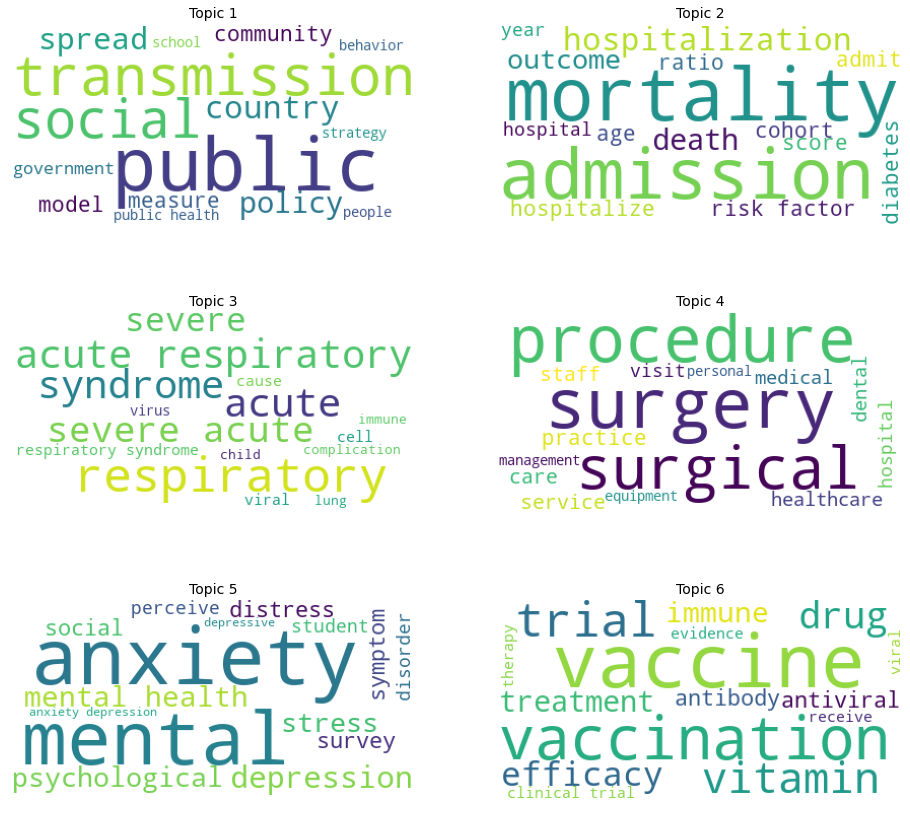

In [81]:
fig = plt.figure(figsize=(16,15))
for label,word_prob_pairs in top_n_words.items():
    top_15_words_prob_pairs = dict(word_prob_pairs[:15])
    #probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    ax= fig.add_subplot(3,2,label+1)
    wcloud = wordcloud.WordCloud(background_color='white')
    wcloud.generate_from_frequencies(top_15_words_prob_pairs)
    ax.imshow(wcloud)
    for pos in ['left','right','top','bottom']:
        ax.spines[pos].set_color(None)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Topic {label+1}' ,fontsize=14)

1. The first topic is similar with topic 4 generated by LDA, talking about the transmission dynamic of the virus. 
2. The second topic is similar with topic 6 generated by LDA, talking about the death
3. The third topic is similar with topic 3 generated by LDA, but seems more specific here, talking about one of the severe symptoms: respiratory .
4. The fourth topic is similar with topic 5 generated by LDA, but seems more specific here, talking about one of the public service: healthcare service.
5. The fifth topic is similar with topic 2 generated by LDA, but seems more specific here, talking about negative emotions like anxiety and distree.
6. The sixth topic is probably similar with topic 1 generated by LDA, talking about the treatment methods.

## Dimension Reduction with AutoEncoder

I use this [blog](https://blog.keras.io/building-autoencoders-in-keras.html) as a guidance to build the autoencoder

In [49]:
ENCODING_DIM = 32
input_embedding = tf.keras.layers.Input(shape=(sentence_embeddings.shape[1],))
encoded = tf.keras.layers.Dense(128,activation='relu')(input_embedding)
encoded = tf.keras.layers.Dense(64,activation='relu')(encoded)
encoded = tf.keras.layers.Dense(ENCODING_DIM,activation='relu')(encoded)

decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(sentence_embeddings.shape[1], activation='linear')(decoded)

autoencoder = tf.keras.models.Model(input_embedding, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [51]:
autoencoder.fit(sentence_embeddings, 
                sentence_embeddings, 
                epochs=500, 
                batch_size=128, 
                shuffle=True,)

Epoch 1/500
56/56 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 2/500
56/56 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 3/500
56/56 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 4/500
56/56 [==============================] - 0s 2ms/step - loss: 0.0671
Epoch 5/500
56/56 [==============================] - 0s 2ms/step - loss: 0.0672
Epoch 6/500
56/56 [==============================] - 0s 4ms/step - loss: 0.0671
Epoch 7/500
56/56 [==============================] - 0s 4ms/step - loss: 0.0670
Epoch 8/500
56/56 [==============================] - 0s 4ms/step - loss: 0.0670
Epoch 9/500
56/56 [==============================] - 0s 4ms/step - loss: 0.0671
Epoch 10/500
56/56 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 11/500
56/56 [==============================] - 0s 3ms/step - loss: 0.0669
Epoch 12/500
56/56 [==============================] - 0s 3ms/step - loss: 0.0668
Epoch 13/500
56/56 [=================

In [68]:
encoder = tf.keras.models.Model(input_embedding,encoded)
encoded_sentence_embeddings = encoder.predict(sentence_embeddings)

## Document Clustering Visualization: Raw Embedding vs Dimension Reduction

In [84]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
#embedding_matrix = tSNE.fit_transform(encoded_sentence_embeddings)
embedding_matrix = tSNE.fit_transform(sentence_embeddings)

df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['topic_idx'] =  cluster_assignment
df_embedding['color'] = df_embedding['topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Transmission of Virus', 1: 'Death', 2: 'Severe Respiratory Symdrone', 
                  3: 'Healthcare Service', 4: 'Mental Health', 5:'Treatment methods'}
df_embedding['label'] = df_embedding['topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of Documents: Raw Embedding', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

Loading BokehJS ...

In [86]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
#embedding_matrix = tSNE.fit_transform(encoded_sentence_embeddings)
embedding_matrix = tSNE.fit_transform(encoded_sentence_embeddings)

df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['topic_idx'] =  cluster_assignment
df_embedding['color'] = df_embedding['topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Transmission of Virus', 1: 'Death', 2: 'Severe Respiratory Symdrone', 
                  3: 'Healthcare Service', 4: 'Mental Health', 5:'Treatment methods'}
df_embedding['label'] = df_embedding['topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of Documents: Embeddings after Dimension Reduction', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

Loading BokehJS ...

The boundaries between documents of different topics are not very clear, in both raw embeddings or embeddings after dimension reduction.

# Conclusion

To sum up, the topics extracted from these two methods are similar, but the topics from the second method are more specific.

LDA is always a traditional and go-to algorithm for topic analysis. You can extract real ideas from topics and cluster documents based on topics easily with this algorithm. The advantage of LDA is that you can get relatively clear boundaries when clustering the documents while the disadvantage of LDA is that the real ideas from topics are somewhat ambiguous because it is not easy to tune the hyparameters  of this unsupervised learning algorithm. 

Bert and its modified versions nowadays outperform everything and achieve state-of-art results in all kinds of NLP tasks. Hence, SentenceBert can give very good representation of the documents. The advantage of the second method is that the real ideas from topics are more meaningful and interpretable while the disadvantage of it is that the decision boundary of documents clustering is not clear.

**What's next?**

1. Combine LDA with Bert embedding for better clustering results.
2. Try larger topic numbers